# Notebook : 01_data_exploration.ipynb (structure JSON via code)
# 1 - Importation
## 1.1 - Librairies

In [1]:
# notebooks/01_data_exploration.ipynb

# 🔧 Librairies de base
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
from pathlib import Path

# 🖼️ Traitement d'images
import cv2
from PIL import Image
import albumentations as A

# 📚 Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from keras.utils import img_to_array, load_img
from keras.models import Model
from keras.layers import Input

# 📊 Évaluation / Modèles
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 🧪 Tests éventuels
import pytest

# GPU
import GPUtil

# 🌱 Environnement
from dotenv import load_dotenv
load_dotenv()

# (optionnel, selon tracking)
import mlflow

# Ajout du chemin pour accéder aux modules
import sys
sys.path.append(str(Path("..") / "src"))

KeyboardInterrupt: 

## 1.2 - GPU - Détection & Allocation mémoire dynamique

In [ ]:
print("\n🧠 Interpréteur actif :", sys.executable)
print("📦 TensorFlow version :", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU détecté : {gpus}")
        print("🧪 Détails GPU :", device_lib.list_local_devices())
    except RuntimeError as e:
        print(f"⚠️ Erreur allocation GPU : {e}")
else:
    print("❌ Aucun GPU détecté. Exécution sur CPU.")


🧠 Interpréteur actif : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\Scripts\python.exe
📦 TensorFlow version : 2.15.0
❌ Aucun GPU détecté. Exécution sur CPU.


In [ ]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  5% | 19% |


In [ ]:
# Bloc visuel de disponibilité - TensorBoard GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14476095466668444868
xla_global_id: -1
]


## 1.3 - Configuration des chemins et environnement
- Chemins relatifs depuis notebooks/, vers data/ à la racine du projet

In [ ]:
project_root = Path(".." ).resolve()
src_path = project_root / "src"

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

data_dir = project_root / "data"
raw_dir = data_dir / "raw"
processed_dir = data_dir / "processed"
models_dir = project_root / "models"
outputs_dir = project_root / "outputs"
scripts_dir = project_root / "scripts"

# Dossiers images & masks plats
image_dir = raw_dir / "images"
mask_dir = raw_dir / "masks"
augmented_dir = raw_dir / "augmented"

# Fichiers de données transformées (version augmentée uniquement)
train_path = processed_dir / "augmented" / "train.npz"
val_path   = processed_dir / "augmented" / "val.npz"
test_path  = processed_dir / "augmented" / "test.npz"

# Création du dossier figures
figures_dir = outputs_dir / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

# ⚙️ Paramètres globaux (config)
IMG_SIZE = (256, 256)
ALPHA_OVERLAY = 0.6

## 1.4 - Imports internes

In [ ]:
from data_preprocessing.class_mapping import FLAT_CLASS_MAPPING, CLASS_NAME_MAPPING
from data_preprocessing.preprocessing import prepare_dataset
from data_generator.generator import AlbumentationDataGenerator
from utils.viz_utils import plot_class_legend, get_custom_colormap, show_image_mask_grid_overlay, plot_filtered_image_mask_grid, plot_raw_images_grid

## 1.5 - Vérification du contenu

In [ ]:
image_list = sorted(os.listdir(image_dir))
mask_list = sorted(os.listdir(mask_dir))
print(f"Nombre d'images: {len(image_list)}\nNombre de masques: {len(mask_list)}")

for i in range(len(image_list)):
    assert image_list[i] == mask_list[i]
print(image_list[2], mask_list[2])

# 🔎 DEBUG - Vérification du mapping masque brut → superclasses
sample_mask_path = list((mask_dir).glob("*.png"))[0]
raw_mask = cv2.imread(str(sample_mask_path), cv2.IMREAD_GRAYSCALE)

print(f"\n🎯 Fichier mask brut inspecté : {sample_mask_path.name}")
print("✅ Valeurs uniques dans le mask brut :", np.unique(raw_mask))

# Appliquer mapping actuel
remapped_mask = np.full_like(raw_mask, fill_value=255)
for src_id, class_id in FLAT_CLASS_MAPPING.items():
    remapped_mask[raw_mask == src_id] = class_id

print("🎨 Valeurs après mapping :", np.unique(remapped_mask))

Nombre d'images: 5000
Nombre de masques: 5000
aachen_000002_000019.png aachen_000002_000019.png

🎯 Fichier mask brut inspecté : aachen_000000_000019.png
✅ Valeurs uniques dans le mask brut : [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]
🎨 Valeurs après mapping : [0 1 2 3 4 5 6 7]


## 1.6 - Visualisation de l'arborescence du projet

In [ ]:
def display_tree(start_path = '.', max_level = 2, prefix = ''):
    start_path = Path(start_path)
    if max_level < 0:
        return
    for path in sorted(start_path.iterdir()):
        if path.name.startswith('.'):
            continue  # ignore fichiers cachés
        print(f"{prefix}├── {path.name}")
        if path.is_dir():
            display_tree(path, max_level - 1, prefix + "│   ")

In [ ]:
display_tree("..", max_level = 2)

├── api
├── app
├── config
│   ├── config_gpu.yaml
├── data
│   ├── P8_Cityscapes_gtFine_trainvaltest
│   │   ├── gtFine
│   │   ├── license.txt
│   │   ├── README
│   ├── P8_Cityscapes_leftImg8bit_trainvaltest
│   │   ├── leftImg8bit
│   │   ├── license.txt
│   │   ├── README
│   ├── processed
│   │   ├── augmented
│   │   ├── test
│   │   ├── test.npz
│   │   ├── train
│   │   ├── train.npz
│   │   ├── val
│   │   ├── val.npz
│   ├── raw
│   │   ├── augmented
│   │   ├── images
│   │   ├── masks
├── environment.yml
├── launch_tf_gpu_env.bat
├── Makerfile
├── models
│   ├── best_unet_vgg16.h5
│   ├── best_unet_vgg16_history.pkl
│   ├── optuna_vgg16_bs16_ep20.h5
│   ├── optuna_vgg16_bs16_ep20_history.pkl
│   ├── optuna_vgg16_bs16_ep20_metrics.csv
│   ├── optuna_vgg16_bs16_ep20_training_plot.png
│   ├── optuna_vgg16_bs16_ep30.h5
│   ├── optuna_vgg16_bs16_ep30_history.pkl
│   ├── optuna_vgg16_bs16_ep30_metrics.csv
│   ├── optuna_vgg16_bs16_ep30_training_plot.png
│   ├── optuna_vgg16_bs4_

## 1.7 - Mapping des classes

In [ ]:
print("🧾 Mapping des classes (ID → Nom) :\n")
for class_id, class_name in CLASS_NAME_MAPPING.items():
    print(f"  Classe {class_id} : {class_name}")

🧾 Mapping des classes (ID → Nom) :

  Classe 0 : void
  Classe 1 : flat
  Classe 2 : construction
  Classe 3 : object
  Classe 4 : nature
  Classe 5 : sky
  Classe 6 : human
  Classe 7 : vehicle


# 2 - Chargement des fichiers .npz (prétraités)

In [ ]:
if not (train_path.exists() and val_path.exists() and test_path.exists()):
    print("[INFO] Fichiers .npz absents. Lancement du preprocessing.")
    prepare_dataset(
        image_dir = raw_dir / "images",
        mask_dir  = raw_dir / "masks",
        output_dir = processed_dir / "augmented",
        mapping_dict = FLAT_CLASS_MAPPING,
        img_size = IMG_SIZE,
        force_preprocessing = False,
        mlflow_tracking = True
    )
else:
    print("[INFO] Fichiers .npz déjà présents. Pas de preprocessing nécessaire.")

[INFO] Fichiers .npz déjà présents. Pas de preprocessing nécessaire.


In [ ]:
train = np.load(train_path)
val = np.load(val_path)
test = np.load(test_path)
X_train, y_train = train["X"], train["Y"]
X_val, y_val     = val["X"], val["Y"]
X_test, y_test   = test["X"], test["Y"]

# 3 - Aperçu de l'augmentation avec Albumentations (via DataGenerator)

In [ ]:
preview_generator = AlbumentationDataGenerator(
    image_dir = raw_dir / "images",
    mask_dir = raw_dir / "masks",
    batch_size = 4,
    img_size = IMG_SIZE,
    augment = True,
    shuffle = True
)

In [ ]:
X_batch, y_batch = preview_generator[0]

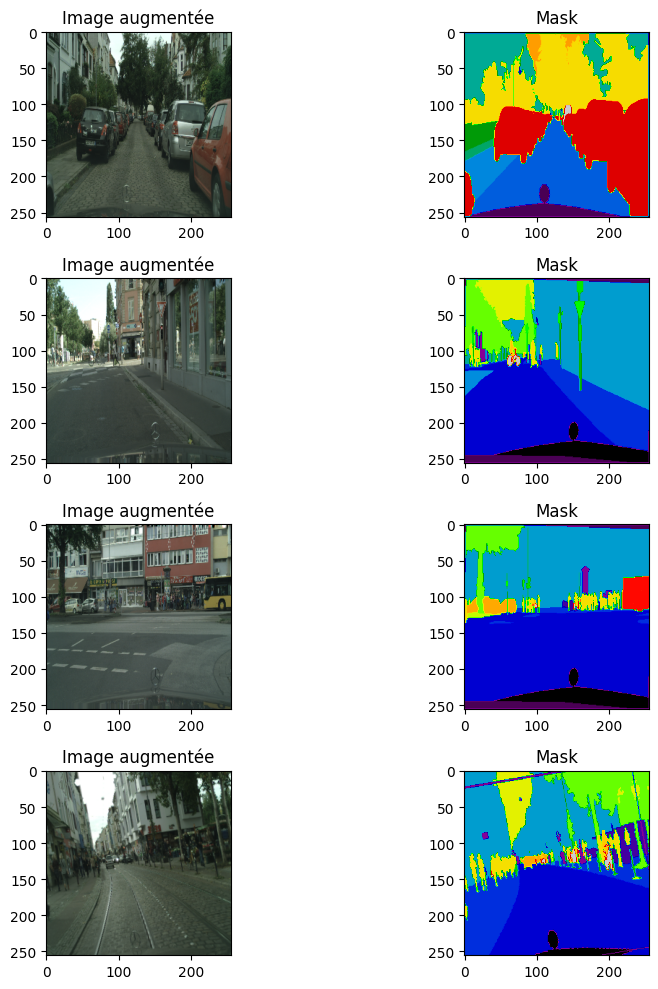

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
for i in range(4):
    axes[i, 0].imshow(X_batch[i])
    axes[i, 0].set_title("Image augmentée")
    axes[i, 1].imshow(y_batch[i], cmap = 'nipy_spectral')
    axes[i, 1].set_title("Mask")
plt.tight_layout()
plt.savefig(outputs_dir / "figures" / "preview_generator_overlay.png")
plt.show()

# 4 - Statistiques des données

In [ ]:
print("[INFO] Taille des images :", X_train.shape[1:])
print("[INFO] Taille des masks  :", y_train.shape[1:])
print("[INFO] Nombre d'images d'entraînement :", X_train.shape[0])

[INFO] Taille des images : (256, 256, 3)
[INFO] Taille des masks  : (256, 256)
[INFO] Nombre d'images d'entraînement : 4000


In [ ]:
unique_labels = np.unique(y_train)
print("[INFO] Labels uniques dans y_train :", unique_labels)

[INFO] Labels uniques dans y_train : [0 1 2 3 4 5 6 7]


[IMG] Images brutes sauvegardées dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\outputs\figures\raw_train_images.png


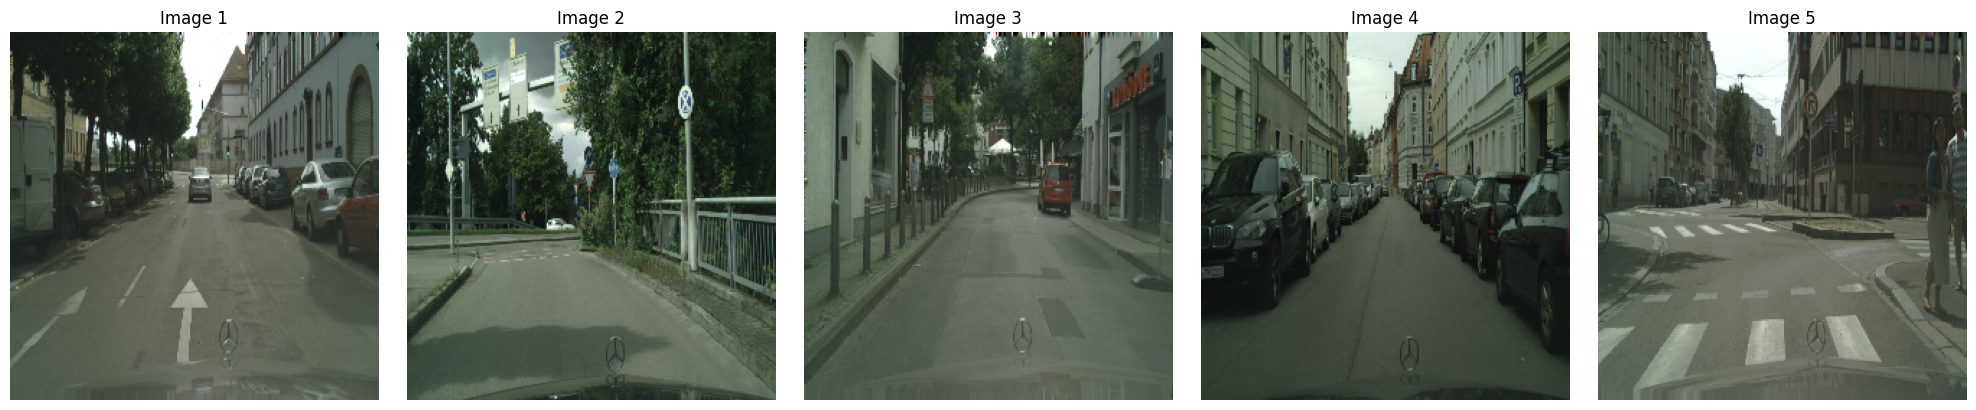

In [ ]:
plot_raw_images_grid(
    X_train,
    save_path=outputs_dir / "figures" / "raw_train_images.png",
    n=5
)

# 5 - Distribution des classes + légende

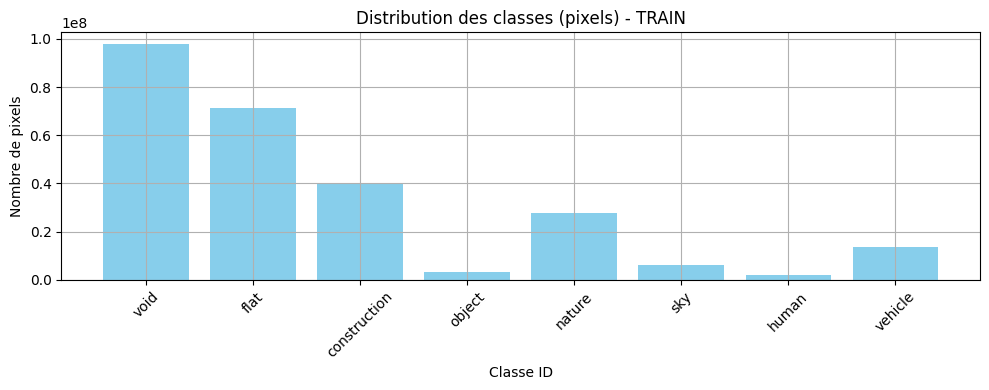

In [ ]:
flat = y_train.flatten()
class_counts = np.bincount(flat[flat != 255], minlength = len(CLASS_NAME_MAPPING))
plt.figure(figsize=(10, 4))
plt.bar(range(len(class_counts)), class_counts, color = "skyblue")
plt.title("Distribution des classes (pixels) - TRAIN")
plt.xlabel("Classe ID")
plt.ylabel("Nombre de pixels")
plt.xticks(range(len(CLASS_NAME_MAPPING)), list(CLASS_NAME_MAPPING.values()), rotation = 45)
plt.grid(True)
plt.tight_layout()
plt.savefig(outputs_dir / "figures" / "class_distribution_train.png")
plt.show()

# 6 - Visualisation superposée (overlay masks)

[FIG] Figure filtrée sauvegardée dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\outputs\figures\train_overlay_preview_filtered.png


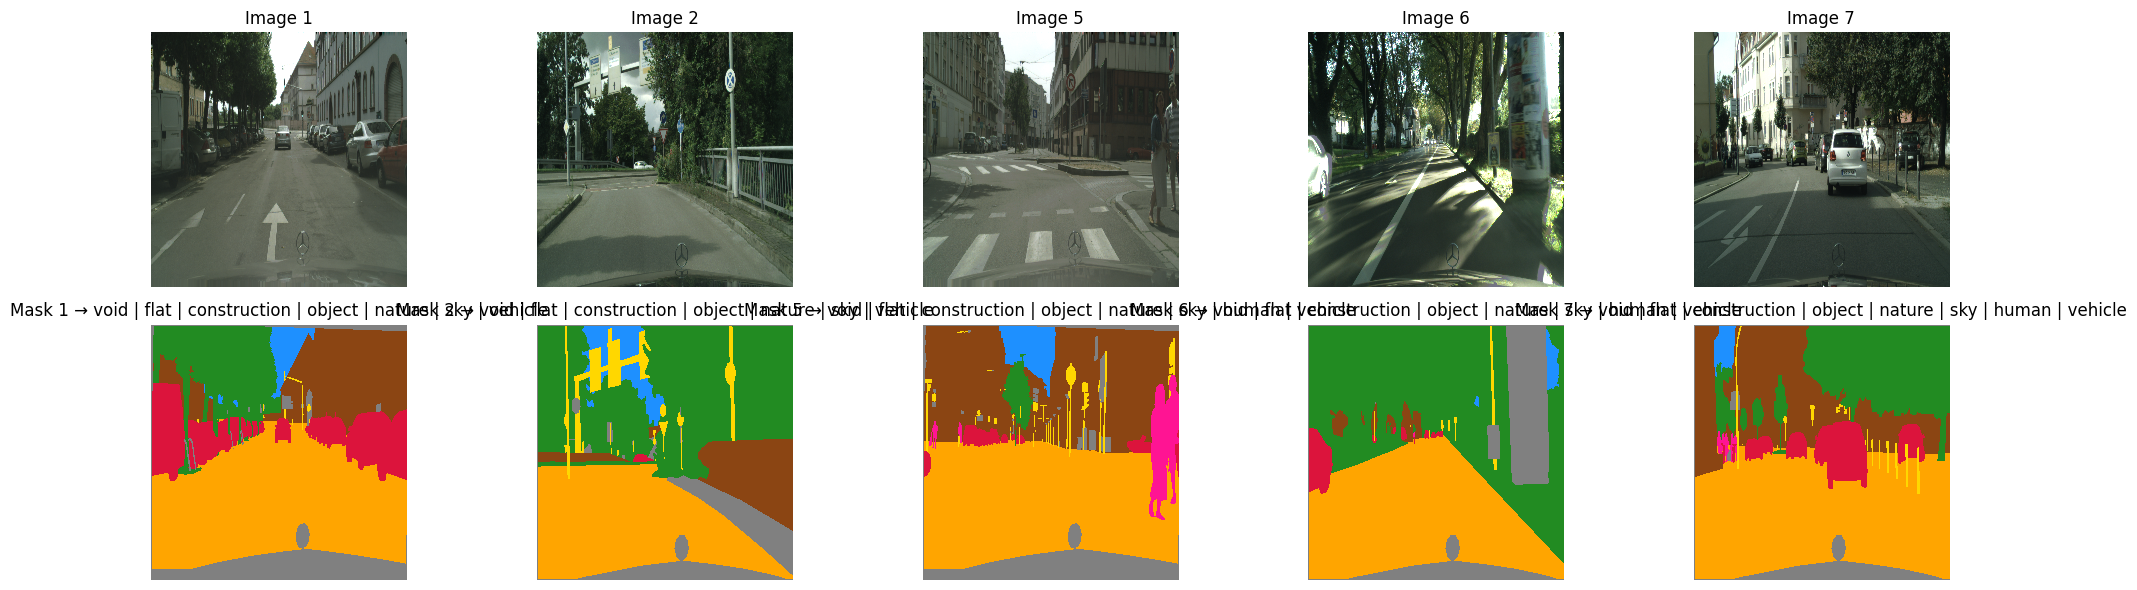

In [ ]:
plot_filtered_image_mask_grid(
    X_train,
    y_train,
    class_mapping=CLASS_NAME_MAPPING,
    save_path=outputs_dir / "figures" / "train_overlay_preview_filtered.png",
    n=5,
    alpha=ALPHA_OVERLAY
)

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\notebooks\..\src\utils\viz_utils.py:118: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  plt.tight_layout()
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\2-python\venv_p8\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


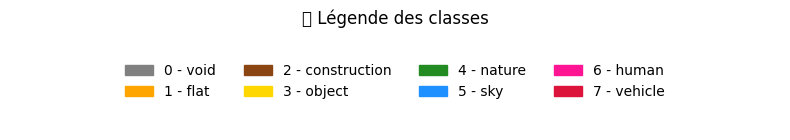

In [ ]:
plot_class_legend()

# 7 - Comparaison train/val/test

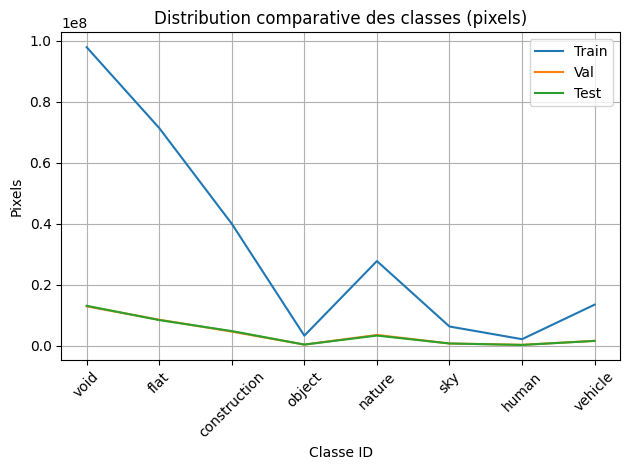

In [ ]:
for label_set, name in zip([y_train, y_val, y_test], ["Train", "Val", "Test"]):
    flat = label_set.flatten()
    counts = np.bincount(flat[flat != 255], minlength=len(CLASS_NAME_MAPPING))
    plt.plot(range(len(counts)), counts, label=name)

plt.title("Distribution comparative des classes (pixels)")
plt.xlabel("Classe ID")
plt.ylabel("Pixels")
plt.xticks(range(len(CLASS_NAME_MAPPING)), list(CLASS_NAME_MAPPING.values()), rotation = 45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(outputs_dir / "figures" / "class_distribution_comparison.png")
plt.show()